In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ttim import *

### Theis

In [2]:
from scipy.special import exp1
def theis(r, t, T, S, Q):
    u = r ** 2 * S / (4 * T * t)
    h = -Q / (4 * np.pi * T) * exp1(u)
    return h

In [3]:
T = 500
S = 1e-4
t = np.logspace(-5, 0, 100)
r = 30
Q = 788

In [4]:
htheis = theis(r, t, T, S, Q)

In [5]:
ml = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1)
w = DischargeWell(ml, tsandQ=[(0, Q)])
ml.solve()
h = ml.head(r, 0, t)

self.Neq  0
No unknowns. Solution complete


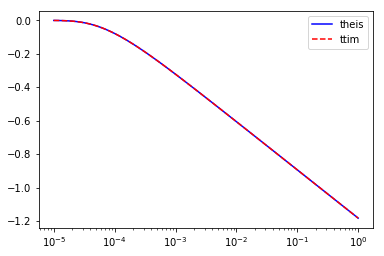

In [6]:
plt.semilogx(t, htheis, 'b', label='theis')
plt.semilogx(t, h[0], 'r--', label='ttim')
plt.legend(loc='best')

In [7]:
from scipy.special import exp1
def theis2(r, t, T, S, Q, tend):
    u1 = r ** 2 * S / (4 * T * t)
    u2 = r ** 2 * S / (4 * T * (t[t > tend] - tend))
    h = -Q / (4 * np.pi * T) * exp1(u1)
    h[t > tend] -= -Q / (4 * np.pi * T) * exp1(u2)
    return h

In [8]:
ml2 = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=10)
w2 = DischargeWell(ml2, tsandQ=[(0, Q), (1, 0)])
ml2.solve()

self.Neq  0
No unknowns. Solution complete


In [9]:
t2 = np.linspace(0.01, 2, 100)
htheis2 = theis2(r, t2, T, S, Q, tend=1)
h2 = ml2.head(r, 0, t2)

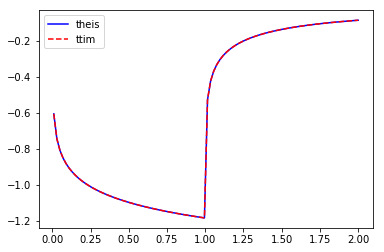

In [10]:
plt.plot(t2, htheis2, 'b', label='theis')
plt.plot(t2, h2[0], 'r--', label='ttim')
plt.legend(loc='best')

### Hantush

In [15]:
T = 500
S = 1e-4
c = 1000
t = np.logspace(-5, 0, 100)
r = 30
Q = 788

In [28]:
from scipy.integrate import quad
def integrand_hantush(y, r, lab):
    return np.exp(-y - r ** 2 / (4 * lab ** 2 * y)) / y

def hantush(r, t, T, S, c, Q, tstart=0):
    lab = np.sqrt(T * c)
    u = r ** 2 * S / (4 * T * (t - tstart))
    F = quad(integrand_hantush, u, np.inf, args=(r, lab))[0]
    return -Q / (4 * np.pi * T) * F

hantushvec = np.vectorize(hantush)

In [29]:
ml = ModelMaq(kaq=25, z=[21, 20, 0], c=[1000], Saq=S/20, topboundary='semi', tmin=1e-5, tmax=1)
w = DischargeWell(ml, tsandQ=[(0, Q)])
ml.solve()

self.Neq  0
No unknowns. Solution complete


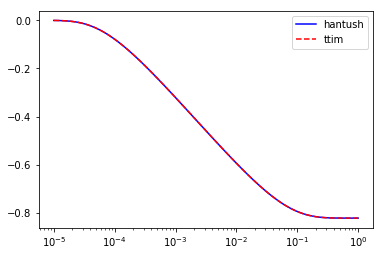

In [30]:
hhantush = hantushvec(30, t, T, S, c, Q)
h = ml.head(r, 0, t)
plt.semilogx(t, hhantush, 'b', label='hantush')
plt.semilogx(t, h[0], 'r--', label='ttim')
plt.legend(loc='best');